In [1]:
######################################################
### Attaching and downloading necessary packagaes ####
######################################################
# if (!requireNamespace("BiocManager", quietly = FALSE))
#     install.packages("BiocManager")
# BiocManager::version()
# library("devtools")
# devtools::install_github("broadinstitute/infercnv", force=TRUE)
# detach("package:infercnv", unload=T)  ### package infercnv_1.15.3  seems to work fine
library(infercnv)
#### loading packages and others 
library("Seurat")
library("tidyverse")
#remotes::install_github("mojaveazure/seurat-disk")
library("SeuratDisk")
#install.packages("ggplot2")
library(ggplot2)
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
library(DoubletFinder)
library(dplyr)
library(tidyverse)

Attaching SeuratObject

-- Attaching core tidyverse packages ---------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.1     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [9]:
## Step 1 . Read a scRNA file 
dat <- Read10X_h5("/data/kumarr9/scRNA/RU1293A_HTAN_MSK.h5")

## step 2 . creating seurat object with with desired cell and gene parameters and also name the project
dat_seurat_obj <- CreateSeuratObject(counts = dat, min.cells = 3, min.features = 200, project = 'SCLC')

## step 3 . Identifying mitochindrial contamination-- and adding it to seurat object -- use MT when human and mt when mouse
dat_seurat_obj[["percent.mt"]] <- PercentageFeatureSet(dat_seurat_obj, pattern = "^MT-")
#View(dat_seurat_obj@meta.data) ## to visualize the data to see mitochondrial cells contamination

## step 4. plotting the mitochondrial contamination or data distribution
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/data_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()

## step 5. viewing data distribution before mitochondrial contamination removal
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/data_distribution.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features <- plot1 + plot2
SCAF3163_features
dev.off()

## step 6. Removing low quality cells and mitochondrial contamination
dat_seurat_obj_filtered <- subset(dat_seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

### just to see what number of cells left after feature selection 
#dat_seurat_obj
#dat_seurat_obj_filtered

## step 7. plots the results after filtering or filtered features
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/data_filtered_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj_filtered, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()

png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/data_distribution_filtered_features.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features_filtered <- plot1 + plot2
SCAF3163_features_filtered
dev.off()
#### Before any kind of scRNA, need to do the Normalization ###
### After removing unwanted cells from the dataset, the next step is to normalize the data. I employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result

## step 8. Normalization of the data 
dat_seurat_obj_filtered <- NormalizeData(dat_seurat_obj_filtered)

## step 9. Identifying highly variable features from the normalized data 
## We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). 
## focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.
dat_seurat_obj_filtered <- FindVariableFeatures(dat_seurat_obj_filtered, selection.method = "vst")
# Identify the 10 most highly variable genes  (change to to your desired number of genes)
top10 <- head(VariableFeatures(dat_seurat_obj_filtered), 10)

# plot variable features with and without labels
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/most_variable.jpg", width = 3000, height = 2000, res=300)
plot1 <- VariableFeaturePlot(dat_seurat_obj_filtered)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
SCAF3163_filterd_variable <- plot1 + plot2
SCAF3163_filterd_variable
dev.off()

## step 10. scale the data, Regression should be done during scaling of the data 
#(Note - here, we can also, remove unwanted source of vaiation like mitochondrial cell or cell cycle etc., see vignettes for more details)
# Shifts the expression of each gene, so that the mean expression across cells is 0
#Scales the expression of each gene, so that the variance across cells is 1
#This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
#The results of this are stored in pbmc[["RNA"]]@scale.data
#############################################
### Parth ask to assign cell cycle score ####
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
dat_seurat_obj_filtered <- CellCycleScoring(dat_seurat_obj_filtered, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
### Regressing out cell cycle from the object ###
dat_seurat_obj_filtered$CC.Difference <- dat_seurat_obj_filtered$S.Score - dat_seurat_obj_filtered$G2M.Score
dat_seurat_obj_filtered <- ScaleData(dat_seurat_obj_filtered, vars.to.regress = "CC.Difference", features = rownames(dat_seurat_obj_filtered))
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/difference_regressed_cell_cyle_RU1293A.jpg", width = 3000, height = 2000, res=300)
dat_seurat_obj_filtered <- RunPCA(dat_seurat_obj_filtered, features = c(s.genes, g2m.genes))
DimPlot(dat_seurat_obj_filtered)
dev.off()


## step 11. Run PCA to reduce the dimensionality
# By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset, like this pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
dat_seurat_obj_filtered <- RunPCA(object = dat_seurat_obj_filtered)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/elbow.jpg", width = 3000, height = 2000, res=300)
ElbowPlot(dat_seurat_obj_filtered)
dev.off()
# Examine and visualize PCA results a few different ways
#print(dat_seurat_obj_filtered[["pca"]], dims = 1:5, nfeatures = 5)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/PCA_plots_heterogeneity.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "pca")
dev.off()


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."


png 
  2

Warning message in cor(x = data[, 1], y = data[, 2]):
"the standard deviation is zero"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."


png 
  2

Warning message in cor(x = data[, 1], y = data[, 2]):
"the standard deviation is zero"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


png 
  2

Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Regressing out CC.Difference

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 1 features requested have not been scaled (running reduction without them): MLF1IP"
Warning message in irlba(A = t(x = object), nv = npcs, ...):
"You're computing too large a percentage of total singular values, use a standard svd instead."
PC_ 1 
Positive:  UBE2C, DLGAP5, NUF2, CCNB2, TPX2, NUSAP1, TYMS, CDCA8, CENPF, BIRC5 
	   HMGB2, ATAD2, MKI67, CLSPN, CDC20, TOP2A, RRM2, CCNE2, SMC4, USP1 
	   PCNA, CDCA3, CENPA, RFC2, CKS1B, GMNN, KIF2C, CDK1, GTSE1, CDC6 
Negative:  CTCF, GAS2L3, RANGAP1, BLM, CDC25C, CHAF1B, PRIM1, EXO1, CDC45, BRIP1 
	   CKAP5, KIF20B, MCM5, FAM64A, RAD51, MCM6, TIPIN, MSH2, G2E3, CDCA7 
	   LBR, CDCA2, E2F8, NCAPD2, ANLN, CBX5, TUBB4B, TACC3, POLA1, MCM2 
PC_ 2 
Positive:  RRM2, MKI67

png 
  2

PC_ 1 
Positive:  PKIB, PCP4, CKB, BEX3, HES6, STMN1, CCER2, BEX2, SIX1, BEX1 
	   PGF, NRN1, CD24, IGFBP2, MYO6, TCEAL2, NEFM, IRX2, BNIP3, CHGA 
	   FAM213A, GSTM3, HSPA2, PSIP1, SCGB2A1, NDUFA4L2, CDKN2A, MARCKSL1, RBM24, DAAM1 
Negative:  SRGN, S100A11, CD74, LGALS1, S100A10, S100A4, PTPRC, HLA-DRA, CD44, HLA-DPA1 
	   LCP1, LAPTM5, TYROBP, HLA-DRB1, ARPC1B, TNFRSF1B, CTSS, ARHGDIB, GMFG, ITGB2 
	   HLA-DPB1, FCER1G, CD48, AKAP13, LGALS3, PLEK, HCST, MSN, CORO1A, LYZ 
PC_ 2 
Positive:  BGN, SOD3, CALD1, COL3A1, COL18A1, SPARCL1, NOTCH3, TPM2, CAV1, LHFP 
	   MYL9, IGFBP7, COL4A1, COL4A2, CARMN, ACTA2, RGS5, PDGFRB, FILIP1L, TAGLN 
	   COL6A2, A2M, MYLK, FN1, C11ORF96, HIGD1B, CSRP2, RARRES2, TFPI, PRKCDBP 
Negative:  CD3D, TRBC2, CD2, CD7, PTPRC, CD3E, CORO1A, CD3G, CD52, GZMA 
	   CST7, NKG7, TRAC, CCL5, CXCR4, RAC2, LTB, CYTIP, TRBC1, HCST 
	   CD48, CD247, GZMM, GZMB, LCK, ACAP1, GZMH, CD37, IL2RG, DUSP2 
PC_ 3 
Positive:  IL1B, S100A9, LYZ, CXCL8, FCER1G, S100A8, PLAUR, AIF1, T

png 
  2

png 
  2

In [27]:
## step 12. clusters the cells 
# Now using the elbow method we determine the neighbours, make the clusters of neighbour and then ran the UMAP to plot the same
dat_seurat_obj_filtered <- "FindNeighbors"(dat_seurat_obj_filtered, dims = 1:20) ## can change dims according to your needs
dat_seurat_obj_filtered <- FindClusters(dat_seurat_obj_filtered, resolution=c(1)) ### here resolution (resolution = 0.5 or so) or like this wasy (resoultion=c(0.1, 0.3, 0.5, 0.7, 1)) can be added to see at what resolution your data fits ( resolution here means, how many clusters you want to see in your data, lower the number lower cluster anf higher the number higher clusters)
View(dat_seurat_obj_filtered@meta.data)
DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.1", label=TRUE)
#DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.9", label=TRUE)
#DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.7", label=TRUE)
#DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.5", label=TRUE)
# optional step (to set the granularity of the data, i mean the number of clusters to be shown in UMAP)
## seeing or setting identity of clusters  
## Idents function store the identity of cluster
#head(Idents(dat_seurat_obj_filtered), 5) 
#Idents(dat_seurat_obj_filtered)
# when want to set the identity 
#Idents(dat_seurat_obj_filtered) <- SCLC_snn_res_0.3 ## this will set the resolution at 0.3 and make the only number of clusters which are in 0.3 resolution

## choosing best cluster using Dimplot, as above
Idents(dat_seurat_obj_filtered) <- "RNA_snn_res.1" ## setting increased resolution of cluster 
dat_seurat_obj_filtered <- RunUMAP(dat_seurat_obj_filtered, dims = 1:20)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/UMAP.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE)
dev.off()

13:59:26 UMAP embedding parameters a = 0.9922 b = 1.112

13:59:26 Read 2812 rows and found 20 numeric columns

13:59:26 Using Annoy for neighbor search, n_neighbors = 30

13:59:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:59:27 Writing NN index file to temp file /lscratch/1914900/RtmpV9GAly/fileb2db4d18d141

13:59:27 Searching Annoy index using 1 thread, search_k = 3000

13:59:29 Annoy recall = 100%

13:59:30 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:59:33 Initializing from normalized Laplacian + noise (using irlba)

13:59:33 Commencing optimization for 500 epochs, with 111076 positive edges

13:59:52 Optimization finished



png 
  2

png 
  2

png 
  2

Loading required package: fields

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR



NULL


png 
  2

[1] "Creating 937 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.0.1,RNA_snn_res.0.3,RNA_snn_res.0.5,RNA_snn_res.0.7,RNA_snn_res.0.9,RNA_snn_res.1,seurat_clusters,pANN_0.25_0.08_196,DF.classifications_0.25_0.08_196
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>
RU1293A_191767562348387,RU1293A,13438.061,1435,0,-0.173655731,0.04234540,G2M,RU1293A,-0.2160011356,0,0,1,1,0,1,1,0.07666667,Singlet
RU1293A_157062481788340,RU1293A,4686.379,418,0,-0.021402166,0.07290566,G2M,RU1293A,-0.0943078217,1,3,4,3,4,9,9,0.04333333,Singlet
RU1293A_228058935544558,RU1293A,20774.782,2416,0,-0.088715823,-0.08027529,G1,RU1293A,-0.0084405365,0,1,0,0,1,3,3,0.22666667,Singlet
RU1293A_156572856249070,RU1293A,14355.376,1555,0,0.062344891,-0.02827834,S,RU1293A,0.0906232277,0,1,2,5,6,4,4,0.12333333,Singlet
RU1293A_165329207713006,RU1293A,18737.741,2136,0,0.177544961,-0.05998147,S,RU1293A,0.2375264312,0,0,1,1,0,1,1,0.13000000,Singlet
RU1293A_169649542478067,RU1293A,13386.794,1426,0,-0.002225126,-0.03032603,G1,RU1293A,0.0281009081,1,3,4,3,4,9,9,0.27333333,Singlet
RU1293A_199823176355229,RU1293A,9169.732,910,0,-0.046327643,1.02871250,G2M,RU1293A,-1.0750401411,0,0,3,2,3,2,2,0.12666667,Singlet
RU1293A_230609233766134,RU1293A,11071.399,1135,0,-0.181083055,-0.05977485,G1,RU1293A,-0.1213082079,0,1,2,5,6,4,4,0.05000000,Singlet
RU1293A_192118694787828,RU1293A,19518.620,2243,0,0.283366368,-0.11328309,S,RU1293A,0.3966494601,0,0,3,2,3,2,2,0.08666667,Singlet


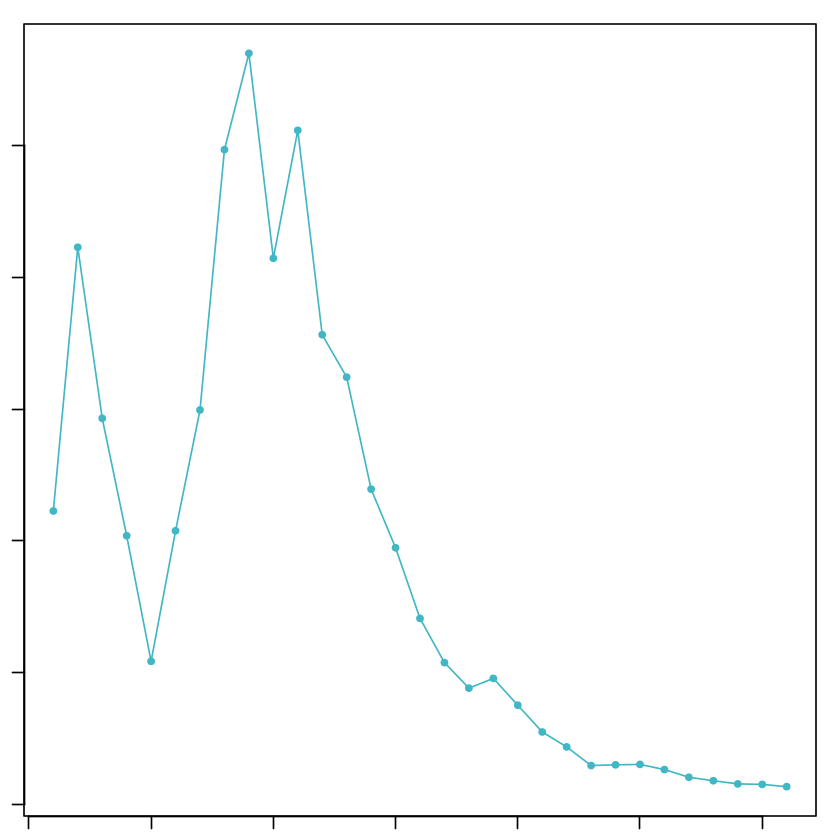

In [28]:
# Plotting for cell cycle scores
##### seeing the object formed for cell cycle scores ####
#head(dat_seurat_obj_filtered[[]])
#str(dat_seurat_obj_filtered)
#Getting Cell cycle scores from the seurat object 
S_score <- dat_seurat_obj_filtered@meta.data$S.Score
g2m_score <- dat_seurat_obj_filtered@meta.data$G2M.Score
cluster_info <- as.numeric(as.character(dat_seurat_obj_filtered@meta.data$seurat_clusters))
Phase <- dat_seurat_obj_filtered@meta.data$Phase
# View(S_score)
# View(g2m_score)
# View(cluster_info)
# View(Phase)
# making dataframe by combining relative stuff what we want to show in plot
cell_df <- cbind(cluster_info, Phase, g2m_score, S_score)

## converting to dataframe and calculating the percentage for stacked bar plot 
# link - https://rpubs.com/techanswers88/stackedbarcharts
cell_df <- data.frame(cell_df)
dt <- cell_df%>%
  dplyr::group_by(cluster_info, Phase)%>%
  dplyr::tally()%>%
  dplyr::mutate(percent=n/sum(n))

## plotting the result 
# pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
# pl <- pl + geom_bar(stat="identity")
# pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
#                      position=position_stack(vjust=0.5), colour="white", size = 2)


# pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 ))
# pl
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/cell_cycle.jpg", width = 2000, height = 1200, res=300)
pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
pl <- pl + geom_bar(stat="identity", position ="fill")
pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
                     position=position_fill(vjust=0.5), colour="black", size =3)

pl <- pl + theme_minimal()
#pl <- pl + labs(title ="Cell cycle score for SCAF2229")
#pl <- pl + labs(subtitle ="plot")
pl <- pl + labs(caption ="Cell cycle score for RU1293A")
pl <- pl  + labs(x ="Cluster", y = "Percentage")
pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 )) + coord_flip()
pl
dev.off()

### cell cycle plot without percent label
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/cell_cycle_RU426B.jpg", width = 2000, height = 1200, res=300)
ggplot(dt, aes(x = cluster_info, y = percent, fill = Phase))+
  geom_col()
dev.off()
### we finished with data pre-processing prior to any doublet finder --- Now we can go for doublet finder 
### Important points - 1. Doublet finder needs to be done on each sample separately, prior to aggregating 
## pk identification --- no ground truth approach
# link -- https://rdrr.io/github/chris-mcginnis-ucsf/DoubletFinder/man/doubletFinder_ParamSweep.html
# link - https://www.youtube.com/watch?v=NqvAS4HgmrE
## required packages 
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
#library(DoubletFinder)

## step 13. Doublet Finding
sweep.list_SCAF3163 <- paramSweep_v3(dat_seurat_obj_filtered, PCs =1:20, sct=FALSE)
sweep.stats_SCAF3163 <- summarizeSweep(sweep.list_SCAF3163, GT = FALSE)
bcmvn_SCAF3163 <- find.pK(sweep.stats_SCAF3163)

### plotting the results --- highest value in plot is your optimal pK
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/optimal_k.jpg", width = 3000, height = 2000, res=300)
ggplot(bcmvn_SCAF3163, aes(pK, BCmetric, group=1))+
geom_point()+
geom_line()
dev.off()


### storing the highest pk value to a pk variable
pK <- bcmvn_SCAF3163 %>%
      filter(BCmetric == max(BCmetric)) %>%
      select(pK)
pK <- as.numeric(as.character(pK[[1]]))


### Homotypic doublet proprotion estimation
annotations <- dat_seurat_obj_filtered@meta.data$seurat_clusters
homotypic.prop <- modelHomotypic(annotations)
nExp_poi <- round(0.076*nrow(dat_seurat_obj_filtered@meta.data))
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))


#### run Doubletfinder 
dat_seurat_obj_filtered <- doubletFinder_v3(dat_seurat_obj_filtered, PCs = 1:20, pN = 0.25, pK = pK, nExp = nExp_poi.adj, reuse.pANN = FALSE, sct = FALSE)
## Viewing data frame 
View(dat_seurat_obj_filtered@meta.data)

In [29]:
# before plotting we need to see following items in our data
names(dat_seurat_obj_filtered@meta.data)
# from there we got the DF.classification, which we need for plot
# homotypic.prop
nExp_poi ## number of expected doublets
nExp_poi.adj ## number of actual doublets

[1] "orig.ident"                       "nCount_RNA"                      
 [3] "nFeature_RNA"                     "percent.mt"                      
 [5] "S.Score"                          "G2M.Score"                       
 [7] "Phase"                            "old.ident"                       
 [9] "CC.Difference"                    "RNA_snn_res.0.1"                 
[11] "RNA_snn_res.0.3"                  "RNA_snn_res.0.5"                 
[13] "RNA_snn_res.0.7"                  "RNA_snn_res.0.9"                 
[15] "RNA_snn_res.1"                    "seurat_clusters"                 
[17] "pANN_0.25_0.08_196"               "DF.classifications_0.25_0.08_196"

[1] 214

[1] 196

In [30]:
### visulaize the doublets 
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.08_196")
dev.off()

## Step 13. Doublets removal
#since we have the name doublets in one of our meta data column of a "dat_seurat_obj_filtered@meta_data", this column has singlet and doublet information
#we can only select singlet by specifying values and so
#Link --- https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/seurat/seurat_01_qc.html
#data.filt = data.filt[, data.filt@meta.data[, DF.name] == "Singlet"]
data.filt = dat_seurat_obj_filtered[, dat_seurat_obj_filtered@meta.data[, "DF.classifications_0.25_0.08_196"] == "Singlet"]
#dim(data.filt)

### ploting the doublet removed dataset for PC & UMAP
#png("/data/kumarr9/scRNA/scRNA_results/SCAF3163/UMAP_doublets_removed.jpg", width = 3000, height = 2000, res=300)
#DimPlot(data.filt, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.01_287")
#dev.off()


### plotting the doublet removed dataset with cluster info 
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/without_doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(data.filt, reduction = "umap", label = TRUE)
dev.off()


## step 14. Finding differentially expressed features (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
dat_filt.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)
# saving all the markers genes
write.csv(dat_filt.markers, file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/positive_marker_gene.csv")
# saving markers genes for a defined crieria
sub_df <- subset(dat_filt.markers, avg_log2FC > 2 & p_val < 0.05)
write.csv(sub_df, file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/positive_marker_gene_significant.csv")
# plotting the marker gene 
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/top5_markers.jpg", width = 5500, height = 3300, res=300)
dat_filt.markers %>%
    group_by(cluster) %>%
    top_n(n = 5, wt = avg_log2FC) -> top5
DoHeatmap(data.filt, features = top5$gene) + NoLegend()
dev.off()


#### new addition, parth ask for few marker gene plots
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/marker_genes.jpg", width = 5500, height = 3300, res=300)
VlnPlot(data.filt, features = c("INSM1", "ASCL1", "YAP1", "NEUROD1", "MYC", "MYCL", "CD44", "ANTXR1"))
dev.off()

png 
  2

png 
  2

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
7.086353e-74,0.8515066,0.801,0.315,1.323943e-69,0,C2CD4B
7.259235e-61,0.8503155,0.609,0.205,1.356243e-56,0,PPP1R3C
9.470008e-42,0.7895576,0.359,0.083,1.769282e-37,1,CHRNA1
2.233951e-34,0.7424499,0.451,0.145,4.173691e-30,1,EGR4
2.564181e-107,1.5942222,0.368,0.025,4.790660e-103,2,DLGAP5
4.960598e-86,1.5595727,0.375,0.039,9.267886e-82,2,CCNB2
3.534514e-14,0.5184062,0.538,0.331,6.603532e-10,3,NFIB
3.887097e-09,0.5059655,0.363,0.218,7.262264e-05,3,PIGH
1.541511e-10,0.9067374,0.391,0.256,2.880006e-06,4,PPP1R3C


png 
  2

png 
  2

Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.


Warning message:
"The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application."
Warning message:
"The following arguments are not used: scale.factor"
Centering and scaling data matrix

The number of cells in your dataset is less than 3,000. Fast mode has been disabled.

CytoTRACE will be run on 1 sub-sample(s) of approximately 2616 cells each using 1 / 1 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done

Warning message:
"Inv

png 
  2

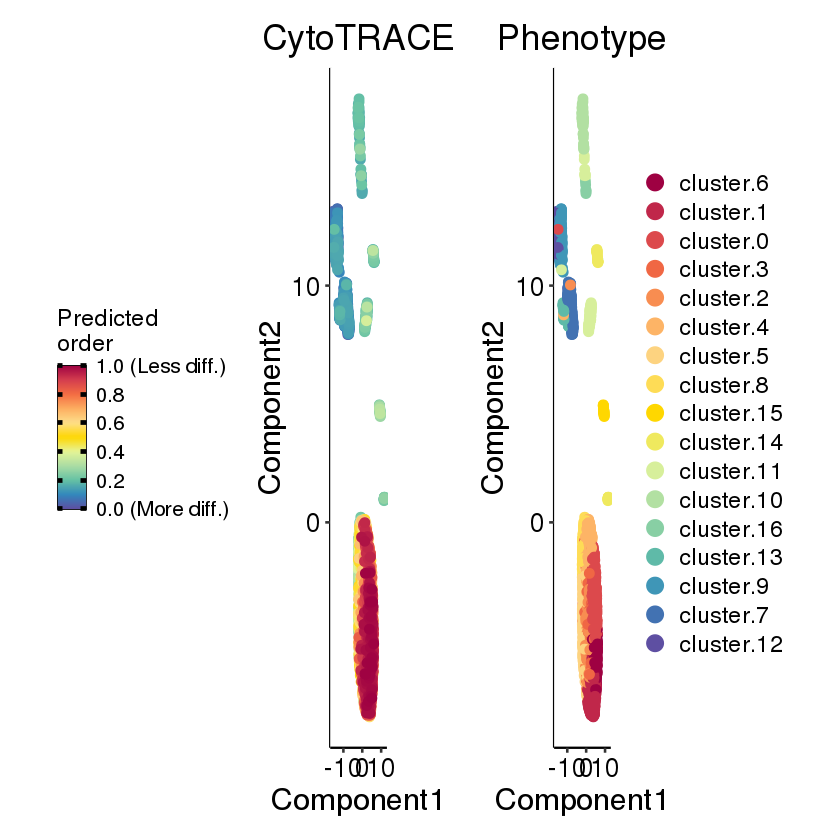

In [31]:
#### Cyotrace analysis starts from here ####
# Link - https://cytotrace.stanford.edu/
####
#install.packages("devtools")
#devtools::install_local("/data/kumarr9/CytoTRACE_0.3.3.tar.gz")
library(CytoTRACE)
#### Cyotrace needs the normalized seurat object
# mtrx should be non-negative(?) => seurat_obj should be normalized using scale.factor=1e6 instead of default (1e5)
seurat_obj <- ScaleData(data.filt, scale.factor=1e6 )
# seurat_obj <- RunPCA(seurat_obj)
# seurat_obj <- JackStraw(seurat_obj)
# seurat_obj <- ScoreJackStraw(seurat_obj)
# seurat_obj <- FindClusters(seurat_obj)
mtrx <- FetchData(seurat_obj, vars=rownames(seurat_obj))
mtrx <- t(mtrx)
## remove genes with 0 reads (of the genes included)
 genes.w.reads <- names(rowSums(mtrx)[rowSums(mtrx)>0])
 mtrx <- mtrx[genes.w.reads,]

 mtrx <- data.frame(mtrx)
 mtrx[mtrx=='.'] <- 0

# ##  outputs a list that includes CytoTRACE score per cell
 Cytotrace.out <- CytoTRACE(mtrx)

 meta <- paste0('cluster.', seurat_obj$seurat_clusters)
 names(meta) <- colnames(seurat_obj)
 names(meta) <- str_replace(names(meta), '-', '.')

# ## UMAP embeddings from Seurat
 umap.embeddings <- as.data.frame(seurat_obj[["umap"]]@cell.embeddings)
 row.names(umap.embeddings) <- str_replace(row.names(umap.embeddings), '-', '.')

 cytotrace.plots <- plotCytoTRACE(Cytotrace.out, emb = umap.embeddings, phenotype = meta, outputDir = '/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/CytoTRACE.output.data')
#### Getting NE, Non-NE gene expression within each cluster of seurat object ####

# Provide a list of genes whose expression you want to see within each cluster
sclc_ne_genes <- c("ASCL1", "BEX1", "BSN", "CELF3", "CHGA", "CHGB","CRMP1", "FAM57B", "INSM1", "KIF1A", 
                   "KIF5C", "MYT1", "RTN1", "RUNDC3A", "SCG3","SEZ6", "SH3GL2", "SYN1", "SYP", "SYT11", 
                    "SYT4", "TAGLN3" ,"TFF3", "TMSB15A", "TMSB15B")
sclc_non_ne_genes <- c("ABCC3", "AHNAK", "ANXA1", "ARHGDIB", "CAV1","CAV2", "CCND1", "CYR61", "EMP1", "EPHA2",
                        "IFITM2", "IFITM3", "ITGB4", "LGALS3", "MYOF","PLAU", "PTGES", "RAB27B", "S100A10", "S100A16",
                        "SLC16A5", "TACSTD2", "TGFBI", "TGFBR2", "YAP1")

# Use the marker genes for each cluster identified in previous steps -
#dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_ne_genes),
                                   ctrl = 20,
                                   name = "NE_genes_expression"
                                   )

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_non_ne_genes),
                                   ctrl = 20,
                                   name = "Non-NE_gene_expression"
                                   )
#Getting NE expression data
gene_data <- seurat_obj@meta.data$NE_genes_expression1
cluster_info <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info <- as.numeric(cluster_info)
data_df <- cbind(gene_data, cluster_info)
data_df <- as.data.frame(data_df)
#data_df <- data.frame(gene_data, cluster_info)
# Set the plot title and y-axis label
plot_title <- "NE gene expression"
y_axis_label <- "Expression"

# Create the violin/box plot
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/NE_NonNE.jpg", width = 3000, height = 1500, res=300)
library(ggplot2)
ne <- ggplot(data_df, aes(x = factor(cluster_info), y = gene_data, col = factor(cluster_info)), add = "jitter") + 
  geom_boxplot(scale = "width") +
  ggtitle(plot_title) + 
  xlab("Cluster") + theme_classic() +
  ylab(y_axis_label) + geom_hline(yintercept=0.00, linetype="dashed", color = "red")

#png("/data/kumarr9/scRNA/scRNA_results/SCAF3163/NE.jpg", width = 3000, height = 2000, res=300)

#Getting Non_NE expression data
gene_data2 <- seurat_obj@meta.data$Non.NE_gene_expression1
cluster_info2 <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info2 <- as.numeric(cluster_info2)
data_df2 <- cbind(gene_data2, cluster_info2)
data_df2 <- as.data.frame(data_df2)
#data_d2f <- data.frame(gene_data2, cluster_info2)
# Set the plot title and y-axis label
plot_title2 <- "Non_NE gene expression"
y_axis_label <- "Expression"
# Create the violin/box plot
non_ne <- ggplot(data_df2, aes(x = factor(cluster_info2), y = gene_data2, col = factor(cluster_info2)), add = "jitter") + 
  geom_boxplot(scale = "width") +
  ggtitle(plot_title2) + 
  xlab("Cluster") + theme_classic() +
  ylab(y_axis_label) + geom_hline(yintercept=0.00, linetype="dashed", color = "red")

NE_NonNE <- ne + non_ne
NE_NonNE
dev.off()

In [32]:
saveRDS(seurat_obj, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/RU1293A_cell_cycle_regress_difference_out_resolution_1.rds")

In [33]:
####################################################################
#### Working with saved object to create InferCNV plots and so #####
####################################################################

#### trying working with seurat object ---
## trying InferCNV from the saved .rds file
RU1293 <- readRDS("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/RU1293A_cell_cycle_regress_difference_out_resolution_1.rds")
load("/data/kumarr9/scRNA/PBMC_seu.RData")

## step 16. mergind the two seurat object 
# link - https://satijalab.org/seurat/articles/merge_vignette.html
# We are merging based on normalized one and hence added the parameters of merge.data=TRUE
RU1293_merged <- merge(RU1293, y = PBMC_seu, add.cell.ids = c("SCLC", "PBMC"), project = "SCLC",
     merge.data = TRUE)
# to see the content of merged object
# SCAF3163_merged@assays$RNA@counts
# dim(SCAF3163_merged)
# dim(SCAF3163)
# dim(PBMC_seu)

## step 17. Getting count matrix from merged dataframe
#str(SCAF3163_merged)
expr_matrix <- GetAssayData(object = RU1293_merged, slot = "counts", assay = "RNA")
# converting the expr_matrix which is dgCmatrix to dataframe 
expr_df <- as.data.frame(expr_matrix)
#expr_df[1:20, 1:20]
write.table(expr_df, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/SCAF_matrix_1.csv", sep = "\t", row.names = TRUE, col.names = TRUE)
### creating gene order matrix for infercnv 
gene_names <- rownames(RU1293_merged)
### converted it to dataframe 
gene_names <- data.frame(gene_names)
## adding chromosme number, start and end to it
## read a gtf file ----
gtf_file <- read.table("/data/SCLCgenomics/rajesh/gene_version_27_cp.gtf")
matching_rows <- gtf_file[gtf_file$V5 %in% gene_names$gene_names, ]
### correcting this dataframe as given in inferCNV package
gene_df <- matching_rows %>% 
  select(V5, everything())
gene_df <- gene_df[, -5]
gene_df = gene_df[!duplicated(gene_df$V5),]
# names(gene_df)[2] <- "chr"
# names(gene_df)[3] <- "start"
# names(gene_df)[4] <- "stop"

###
write.table(gene_df, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/gene_order_1.txt", sep = "\t", row.names = FALSE, col.names = FALSE)
## getting the cluster info from the seurat object/merged object
clust_info <- RU1293_merged@meta.data[, "seurat_clusters", drop=F]
## making dataset what looks like or needed by the inferCNV
clust_info$cellID <- rownames(clust_info)
clust_info$clstr <- paste0('cluster.', clust_info$seurat_clusters)
clust_info_df <- clust_info[, !names(clust_info) %in% "seurat_clusters"]
write.table(clust_info_df, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/annotation_1.txt", sep = "\t", row.names = FALSE, col.names = FALSE)



Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.7 GiB"


In [ ]:
# creating infercnv object
## Modification you need to do before creating object --
#1. Open the annotation.txt file and replace the PBMC cluster with PBMC only 
RU1239_infercnv_obj = CreateInfercnvObject(raw_counts_matrix="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/SCAF_matrix_1.csv",
                                    annotations_file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/annotation_1.txt",
                                    gene_order_file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/gene_order_1.txt",
                                    ref_group_names=c("PBMC"))

# perform infercnv operations to reveal cnv signal
infercnv_obj_1239_new = infercnv::run(RU1239_infercnv_obj,
                             cutoff=0.1,  # use 1 for smart-seq, 0.1 for 10x-genomics
                             out_dir="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/infercnv_results_1",  # dir is auto-created for storing outputs
                             cluster_by_groups=T,   # cluster
                             denoise=T,num_threads = 8,
                             HMM=T
                             )

INFO [2023-06-06 08:57:08] Parsing matrix: /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/SCAF_matrix_1.csv
INFO [2023-06-06 08:58:44] Parsing gene order file: /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/gene_order_1.txt
INFO [2023-06-06 08:58:44] Parsing cell annotations file: /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/RU1293A/alternate/annotation_1.txt
INFO [2023-06-06 08:58:44] ::order_reduce:Start.
INFO [2023-06-06 08:58:46] .order_reduce(): expr and order match.
INFO [2023-06-06 08:58:49] ::process_data:order_reduce:Reduction from positional data, new dimensions (r,c) = 60824,5988 Total=45839877.8176536 Min=0 Max=3089.
INFO [2023-06-06 08:58:53] num genes removed taking into account provided gene ordering list: 7196 = 11.8308562409575% removed.
INFO [2023-06-06 08:58:53] -filtering out cells < 100 or > Inf, removing 0 % of cells
WARN [2023-06-06 08:58:56] Please use "options(scipen = 100)" before running infe

Centering and scaling data matrix

PC_ 1 
Positive:  CHCHD1, ZSWIM8, CAMK2G, FUT11, VCL, AP3M1, ADK, SEC24C, KAT6B, SAMD8 
	   PPP3CB, VDAC2, COMTD1, ZNF503, KCNMA1, POLR3A, RPS24, ZMIZ1, PPIF, EIF5AL1 
	   NUTM2B-AS1, TMEM254, ANXA11, FAM213A, TSPAN14, GHITM, CCSER2, WAPL, LDB3, SNCG 
Negative:  SLC39A10, NABP1, MYO1B, STAT4, STAT1, GLS, NAB1, NCKAP1, DNAJC10, PPP1R1C 
	   SSFA2, TRAK2, ITGA4, UBE2E3, TMEM237, CWC22, SESTD1, ALS2, PLEKHA3, FKBP7 
	   SUMO1, DFNB59, NOP58, PRKRA, OSBPL6, RBM45, BMPR2, TTC30A, AGPS, FAM117B 
PC_ 2 
Positive:  BRI3BP, UBC, SLC15A4, AACS, RIMBP2, NCOR2, DIP2B, STX2, ATF1, METTL7A 
	   RAN, SLC11A2, ZNF664, SFSWAP, ULK1, LETMD1, CCDC92, PUS1, CSRNP2, TFCP2 
	   ATP6V0A2, EP400, GTF2H3, EP400NL, EIF2B1, DDX51, DDX55, TMED2, NOC4L, RILPL1 
Negative:  PLOD2, SLC9A9, PLSCR1, U2SURP, PLSCR5, PLS1, GYG1, ATR, HLTF, XRN1 
	   HPS3, GK5, WWTR1, TFDP2, ATP1B3, COMMD2, RNF7, RNF13, RASA2, PFN2 
	   ZBTB38, SPSB4, TSC22D2, SLC25A36, SERP1, NMNAT3, EIF2A, COPB2, SELEN

INFO [2023-06-06 09:12:00] define_signif_tumor_subclusters(), tumor: cluster.1


Centering and scaling data matrix

PC_ 1 
Positive:  MLST8, PGP, TRAF7, E4F1, SNHG19, ECI1, RAB26, RNPS1, PKD1, CCNF 
	   TSC2, TIGD5, TSTA3, ZNF623, EEF1D, ZNF707, CCDC166, NTHL1, NAPRT, TBC1D24 
	   MAPK15, MROH6, FAM83H, SLC9A3R2, GSDMD, AMDHD2, SCRIB, PUF60, NPW, PDPK1 
Negative:  RNF146, ECHDC1, CENPW, PTPRK, ARHGAP18, TRMT11, SAMD3, HINT3, MED23, STX7 
	   NCOA7, SLC18B1, HEY2, RPS12, HDDC2, EYA4, SMPDL3A, TBPL1, PKIB, SGK1 
	   HBS1L, AHI1, BCLAF1, SERINC1, MAP7, MAP3K5, PEX7, HSF2, SLC35D3, IFNGR1 
PC_ 2 
Positive:  ATP9A, ZFP64, KCNG1, DPM1, TSHZ2, ADNP, ZNF217, RPL12P4, PFDN4, FAM210B 
	   BCAS4, PARD6B, AURKA, CSTF1, PTPN1, RTFDC1, CEBPB, RAE1, RBM38, TMEM189 
	   PMEPA1, VAPB, RAB22A, STX16, UBE2V1, NPEPL1, GNAS, SNAI1, TP53INP2, GGT7 
Negative:  SSFA2, ITGA4, UBE2E3, CWC22, SESTD1, PLEKHA3, FKBP7, DFNB59, PRKRA, OSBPL6 
	   RBM45, TTC30A, AGPS, NFE2L2, HNRNPA3, MTX2, AC016739.1, LNPK, ATP5G3, ATF2 
	   CHN1, CHRNA1, WIPF1, GPR155, SCRN3, CIR1, OLA1, SP3, CDCA7, PDK1 
PC_ 3

INFO [2023-06-06 09:12:01] define_signif_tumor_subclusters(), tumor: cluster.10


Centering and scaling data matrix

PC_ 1 
Positive:  SAV1, ATL1, NIN, MAP4K5, PYGL, ATP5S, TRIM9, L2HGDH, TMX1, SOS2 
	   FRMD6, VCPKMT, GNG2, LINC01588, C14orf166, PTGER2, ARF6, TXNDC16, NEMF, GPR137C 
	   KLHDC2, ERO1A, KLHDC1, POLE2, PSMC6, DNAAF2, MGAT2, STYX, RPL36AL, GNPNAT1 
Negative:  PLEKHM1, FMNL1, NFE2L1, CBX1, HEXIM2, SNX11, SKAP1, HEXIM1, NMT1, HOXB2 
	   DCAKD, C1QL1, HOXB3, EFTUD2, GJC1, ADAM11, HOXB4, CCDC43, GPATCH8, CALCOCO2 
	   FAM171A2, ATP5G1, GRN, UBE2Z, SNF8, SLC25A39, ABI3, RUNDC3A, ZNF652, UBTF 
PC_ 2 
Positive:  ARIH2, P4HTM, ARIH2OS, PRKAR2A, WDR6, IP6K2, TMA7, SHISA5, NME6, NCKIPSD 
	   UQCRC1, MAP4, DHX30, SMARCC1, ELP6, SCAP, KLHL18, KIF9, SETD2, CCDC12 
	   SACM1L, LIMD1, CDCP1, EXOSC7, TUSC2, ZDHHC3, RASSF1, NPRL2, CYB561D2, TMEM115 
Negative:  RILP, PRPF8, SLC43A2, MIR22HG, PITPNA, INPP5K, SMYD4, MYO1C, CRK, RPA1 
	   YWHAE, ABR, SMG6, TIMM22, NXN, MRM3, GLOD4, SRR, GEMIN4, TSR1 
	   FAM57A, SGSM2, VPS53, MNT, RPH3AL, METTL16, PAFAH1B1, CLUH, RAP1GAP2,

INFO [2023-06-06 09:12:02] define_signif_tumor_subclusters(), tumor: cluster.11


Centering and scaling data matrix

PC_ 1 
Positive:  FGF7, FAM227B, GALK2, COPS2, SECISBP2L, CEP152, DUT, MYEF2, EID1, BLOC1S6 
	   SPATA5L1, SHF, DUOX1, SORD, TRIM69, B2M, SPG11, EIF3J, EIF3J-AS1, CTDSPL2 
	   CASC4, WDR76, MFAP1, MAP2K5, IQCH-AS1, SKOR1, AAGAB, IQCH, SMAD3, HYPK 
Negative:  SNX13, HDAC9, AGR2, TWISTNB, TSPAN13, RPL21P75, BZW2, ANKMY2, SP4, DGKB 
	   ETV1, CDCA7L, ARL4A, TMEM106B, RAPGEF5, PHF14, TOMM7, FAM126A, NDUFA4, KLHL7 
	   GLCCI1, NUPL2, UMAD1, RPA3, GPNMB, MIOS, C1GALT1, MALSU1, CCZ1B, IGF2BP3 
PC_ 2 
Positive:  CDC42EP3, CEBPZOS, CEBPZ, CYP1B1, NDUFAF7, PRKD3, EIF2AK2, ATL2, RPLP0P6, GPATCH11 
	   HNRNPLL, HEATR5B, THUMPD2, MAP4K3, MORN2, STRN, GALM, SOS1, SLC8A1, DHX57 
	   GEMIN6, FEZ2, SRSF7, EML4, CRIM1, COX7A2L, FAM98A, BIRC6, MTA3, YIPF4 
Negative:  HIBCH, PMS1, INPP1, ORMDL1, MFSD6, OSGEPL1, STAT1, STAT4, MYO1B, NAB1 
	   GLS, ANKAR, NABP1, SLC39A10, ASNSD1, SLC40A1, WDR75, ZC3H15, NUP35, NCKAP1 
	   DNAJC10, PPP1R1C, SSFA2, ITGA4, UBE2E3, CWC22, SEST

INFO [2023-06-06 09:12:02] define_signif_tumor_subclusters(), tumor: cluster.12


Centering and scaling data matrix

PC_ 1 
Positive:  CD247, CREG1, POU2F1, RCSD1, TADA1, MPZL1, POGK, UCK2, MPC2, TMCO1 
	   DCAF6, ALDH9A1, MGST3, TIPRL, SFT2D2, ATP1B1, CORO1B, NME7, TMEM134, HAGHL 
	   BLZF1, NARFL, AIP, RPUSD1, FBL, DYRK1B, EID2, PSMC4, MAP3K10, AKT2 
Negative:  MAML3, MGST2, SCOC, RAB33B, NAA15, CLGN, NDUFC1, OSBPL10, ELF2, CMTM8 
	   ELMOD2, STT3B, AZI2, RBMS3, TGFBR2, PAXIP1, CMTM7, ACTR3B, PAXIP1-AS1, CMC1 
	   SCLT1, AC144652.1, LINC01003, INSIG1, RNF150, JADE1, CMTM6, TNKS, RBM33, PGRMC2 
PC_ 2 
Positive:  NT5C, ATP5H, JPT1, CDR2L, SUMO2, NUP85, FDXR, GGA3, NAT9, MRPS7 
	   SLC9A3R1, MIF4GD, GPRC5C, SLC25A19, BTBD17, GRB2, TMEM94, KIF19, CASKIN2, RPL38 
	   TSEN54, LLGL2, CDC42EP4, MYO15B, FAM104A, SAP30BP, COG1, GALK1, H3F3B, SSTR2 
Negative:  HP1BP3, EIF4G3, ECE1, BICDL2, IL32, THOC6, DDOST, RAP1GAP, HCFC1R1, ZNF205 
	   USP48, TNFRSF12A, PINK1, ZNF200, HSPG2, CLDN9, LINC00339, PAQR4, CDC42, WNT4 
	   FLYWCH1, ZBTB40, C1QB, FLYWCH2, EPHB2, ELOB, KDM1A, LUZP

INFO [2023-06-06 09:12:03] define_signif_tumor_subclusters(), tumor: cluster.13


Centering and scaling data matrix

PC_ 1 
Positive:  LYST, GPR137B, ERO1B, LGALS8, HEATR1, MTR, FH, CHML, CEP170, SDCCAG8 
	   AKT3, ZBTB18, ADSS, SERPINB9, DESI2, SERPINB6, NQO2, COX20, RIPK1, HNRNPU 
	   EFCAB2, BPHL, SMYD3, TFB2M, TUBB2A, AHCTF1, SCCPDH, ZNF669, CNST, ZNF124 
Negative:  MMP24, MMP24-AS1, EIF6, EDEM2, UQCC1, TRPC4AP, CEP250, GSS, ERGIC3, ACSS2 
	   GGT7, CPNE1, TP53INP2, RBM12, NCOA6, NFS1, MAP1LC3A, DYNLRB1, ROMO1, ITCH 
	   AHCY, EIF2S2, RBM39, RALY, PHF20, SLC20A1, CHCHD5, CKAP2L, CHMP4B, IL1B 
PC_ 2 
Positive:  FEZ2, CRIM1, FAM98A, BIRC6, YIPF4, SLC30A6, SPAST, DPY30, MEMO1, LCLAT1 
	   LBH, YPEL5, WDR43, TRMT61B, ACAP1, TMEM256, PPP1CB, FGF11, CHRNB1, GPS2 
	   ZBTB4, POLR2A, EIF5A, CLDN7, EIF4A1, FOSL2, CD68, ELP5, MPDU1, FXR2 
Negative:  SMG7, LAMC2, DHX9, RGS16, GLUL, IER5, MR1, STX6, KIAA1614, XPR1 
	   ACBD6, QSOX1, CEP350, ENTPD6, ABHD12, PYGB, ACSS1, NINL, APMAP, NANP 
	   TOR1AIP1, DDX59, ZNF337, CST7, TMEM9, HM13, LAD1, TOR1AIP2, ID1, BCL2L1 
PC_ 3 
Pos

INFO [2023-06-06 09:12:03] define_signif_tumor_subclusters(), tumor: cluster.14


Centering and scaling data matrix

PC_ 1 
Positive:  ZNF227, ZNF226, ZNF112, ZNF234, ZNF180, ZNF224, CLPTM1, NECTIN2, CLASRP, ZNF222 
	   APOE, RELB, TOMM40, GEMIN7, ZNF230, MARK4, PPP1R37, ZNF283, TRAPPC6A, ERCC2 
	   SMG9, PPP1R13L, CD3EAP, PLAUR, ERCC1, FOSB, RTN2, CADM4, VASP, OPA3 
Negative:  SLC27A5, ZNF324, RPS5, TBPL1, COQ4, TMSB4XP4, URM1, SPTAN1, GLE1, TRUB2 
	   ODF2, WDR34, SWI5, SGK1, SET, GOLGA2, ZER1, ZDHHC12, TBC1D13, DNM1 
	   ENDOG, HBS1L, CIZ1, ARFIP1, VSTM2L, CTNNBL1, SPOUT1, TTI1, TMEM154, AHI1 
PC_ 2 
Positive:  SMG7, LAMC2, DHX9, RGS16, GLUL, IER5, MR1, STX6, KIAA1614, XPR1 
	   DDX59, ACBD6, TMEM9, LAD1, QSOX1, PHLDA3, CEP350, CSRP1, TOR1AIP1, NAV1 
	   IPO9, TOR1AIP2, TIMM17A, SOAT1, PRPF40A, FMNL2, ARL6IP6, STAM2, RNPEP, RPRM 
Negative:  NDEL1, RPL26, RANGRF, BORCS6, TMEM107, ILVBL, VAMP2, BRD4, AKAP8, PER1 
	   RPS28, ANGPTL4, NDUFA7, RAB11B, CD320, MARCH2, CERS4, HNRNPM, ELAVL1, TIMM44 
	   CTXN1, SNAPC2, TRAPPC1, MAP2K7, PRR36, STXBP2, CHD3, PET100, RASAL3,

INFO [2023-06-06 09:12:04] define_signif_tumor_subclusters(), tumor: cluster.15


Centering and scaling data matrix

PC_ 1 
Positive:  DENND3, PTP4A3, PTK2, AGO2, TSNARE1, CHRAC1, TRAPPC9, ADGRB1, KHDRBS3, ARC 
	   ZFAT, JRK, LY6K, ST3GAL1, THEM6, NDRG1, SLA, LY6E, PHF20L1, EFR3A 
	   GLI4, ASAP1, FAM49B, TOP1MT, PVT1, MYC, RHPN1, LINC00861, MAFA, TRIB1 
Negative:  DCTN6, LEPROTL1, GTF2E2, SARAF, SMIM18, DUSP4, GSR, UBXN8, HBB, KIF13B 
	   RRM1, HBG2, STIM1, RHOG, TRIM22, PPP2CB, PGAP2, HMBOX1, FAM160A2, NUP98 
	   WRN, CHRNA10, SMPD1, ART5, FZD3, APBB1, NRG1, ZNF195, FBXO16, ARFIP2 
PC_ 2 
Positive:  FGFBP2, FAM200B, TAPT1, QDPR, LAP3, MED28, FBXL5, FAM184B, CPEB2, DCAF16 
	   BOD1L1, RAB28, NCAPG, HS3ST1, ZNF518B, LCORL, WDR1, TRMT44, ACOX3, PACRGL 
	   ABLIM2, AFAP1, GRPEL1, DHX15, TADA2B, TBC1D14, CCDC149, KIAA0232, BLOC1S4, MRFAP1L1 
Negative:  TMEM179B, INTS5, TMEM223, TTC9C, NXF1, TAF6L, GANAB, METTL12, POLR2G, HNRNPUL2 
	   UBXN1, UQCC3, STX5, WDR74, SLC3A2, RARRES3, PLA2G16, ATL3, IDH2, CIB1 
	   NGRN, IQGAP1, FURIN, CRTC3, ARPIN, MAN2A2, KLF7, HDDC3, UNC45

INFO [2023-06-06 09:12:04] define_signif_tumor_subclusters(), tumor: cluster.16
INFO [2023-06-06 09:12:04] Less cells in group cluster.16 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-06 09:12:04] define_signif_tumor_subclusters(), tumor: cluster.2


Centering and scaling data matrix

PC_ 1 
Positive:  UBLCP1, TTC1, PWWP2A, RNF145, SLU7, EBF1, PTTG1, CLINT1, LSM11, CCNG1 
	   THG1L, ADAM19, NUDCD2, CYFIP2, HMMR, ITK, MAT2B, MED7, AC026403.1, GEMIN5 
	   WWC1, CNOT8, LARP1, RARS, HAND1, SAP30L, PANK3, GALNT10, FAM114A2, RPL10P9 
Negative:  NUBP2, NME3, MRPS34, SPSB3, HAGH, FAHD1, TELO2, CLCN7, MSRB1, UNKL 
	   NDUFB10, GNPTG, RPS2, TSR3, UBE2I, SNHG9, RPUSD1, TBL3, NARFL, MAFA 
	   RHPN1, ZC3H3, GFER, GSDMD, HAGHL, TOP1MT, MROH6, GLI4, ZNF598, FAM173A 
PC_ 2 
Positive:  PKIB, SMPDL3A, SERINC1, HDDC2, OSER1, TOX2, HSF2, MYBL2, OSER1-AS1, TTPAL 
	   IFT52, HEY2, SERINC3, PKIG, SRSF6, NCOA7, FAM184A, TOMM34, YWHAB, STK4 
	   MATN4, SDC4, CHD6, SYS1, HINT3, PIGT, CTSA, WFDC2, ASF1A, ACOT8 
Negative:  WIZ, RASAL3, AKAP8L, TPM4, AKAP8, BRD4, RAB8A, ILVBL, FAM32A, ZNF333 
	   AP1M1, NDUFB7, KLF2, TECR, DNAJB1, EPS15L1, GIPC1, CHERP, PKN1, SLC35E1 
	   DDX39A, MED26, ADGRE5, SMIM7, ADGRL1, ASF1B, TMEM38A, PRKACA, SIN3B, SAMD1 
PC_ 3 
Positi

INFO [2023-06-06 09:12:05] define_signif_tumor_subclusters(), tumor: cluster.3


Centering and scaling data matrix

PC_ 1 
Positive:  PEX3, ADAT2, FUCA2, AIG1, HIVEP2, ADGRG6, VTA1, PHACTR2, CITED2, TXLNB 
	   HECA, STX7, SLC18B1, MED23, SAMD3, ABRACL, RPS12, REPS1, ARHGAP18, LTV1 
	   CCDC28A, PTPRK, EYA4, ECHDC1, NHSL1, RNF146, HEBP2, TBPL1, SF3B5, TNFAIP3 
Negative:  UNC5A, UIMC1, LINC01574, ZNF346, NSD1, LMAN2, PRELID1, TSPAN17, RGS14, F12 
	   SNCB, GRK6, GPRIN1, PRR7, RNF44, FAF2, CLTB, HIGD2A, NOP16, ARL10 
	   KIAA1191, SIMC1, THOC3, CPLX2, SFXN1, SLC39A4, CPEB4, VPS28, BOD1, CYHR1 
PC_ 2 
Positive:  DNM1L, YARS2, FGD4, PKP2, BICD1, KIF21A, GXYLT1, KIAA1551, YAF2, AMN1 
	   PPHLN1, ZCRB1, FAM60A, DDX11, PUS7L, IPO8, IRAK4, ERGIC2, TWF1, CCDC91 
	   ARID2, SCAF11, KLHL42, SLC38A1, SLC38A2, PCED1B-AS1, ARNTL2, RPAP3, SLC48A1, STK38L 
Negative:  MIR7-3HG, DPP9, MYDGF, FEM1A, TNFAIP8L1, CCDC94, SIRT6, PLIN3, PLIN5, MAP2K2 
	   SEMA6B, UBXN6, MPND, CHAF1A, SH3GL1, KDM4B, ZBTB7A, SAFB2, SAFB, RPL36 
	   PIAS4, C19orf70, HSD11B1L, EEF2, LONP1, DUS3L, DAPK3, NDUFA1

INFO [2023-06-06 09:12:07] define_signif_tumor_subclusters(), tumor: cluster.4


Centering and scaling data matrix

PC_ 1 
Positive:  NUP35, SSFA2, NCKAP1, UBE2E3, ITGA4, ZC3H15, DNAJC10, PPP1R1C, WDR75, CWC22 
	   SESTD1, SLC40A1, ASNSD1, ANKAR, PLEKHA3, OSGEPL1, ORMDL1, FKBP7, PMS1, DFNB59 
	   HIBCH, INPP1, PRKRA, MFSD6, OSBPL6, NAB1, RBM45, GLS, STAT1, TTC30A 
Negative:  ANAPC5, CAMKK2, P2RX4, RNF34, SPPL3, ACADS, UNC119B, KDM2B, MLEC, CABP1 
	   ORAI1, POP5, TMEM120B, RNF10, RHOF, COQ5, LINC01089, SETD1B, PSMD9, BCL7A 
	   MLXIP, B3GNT4, DIABLO, RPLP0, VPS33A, GCN1, CLIP1, RAB35, BICDL1, ZCCHC8 
PC_ 2 
Positive:  HERC3, NAP1L5, PYURF, PPM1K, FAM13A, SPP1, GPRIN3, NUDT9, SNCA, HSD17B11 
	   ATOH1, KLHL8, AFF1, SMARCAD1, ARHGAP24, PDLIM5, WDFY3, UNC5C, MRPS18C, RAP1GDS1 
	   HELQ, EIF4E, COQ2, METAP1, ADH5, PLAC8, DAPP1, COPS4, LAMTOR3, LIN54 
Negative:  THOC3, CPLX2, SIMC1, SFXN1, ARL10, KIAA1191, CPEB4, NOP16, HIGD2A, CLTB 
	   FAF2, BOD1, RNF44, GPRIN1, SNCB, TSPAN17, STC2, LINC01574, UNC5A, UIMC1 
	   ZNF346, BNIP1, NSD1, PRELID1, LMAN2, CREBRF, RGS14, F12, 

INFO [2023-06-06 09:12:08] define_signif_tumor_subclusters(), tumor: cluster.5


Centering and scaling data matrix

PC_ 1 
Positive:  RAB33B, NAA15, NDUFC1, MGST2, MAML3, ELF2, SCOC, CLGN, SCLT1, ELMOD2 
	   RNF150, ZNF330, INPP4B, JADE1, USP38, SMARCA5, ANAPC10, PGRMC2, ABCE1, OTUD4 
	   LARP1B, SMAD1, ABHD18, ZNF827, LSM6, MFSD8, SLC10A7, HSPA4L, POU4F2, INTU 
Negative:  PPP2R5E, SNAPC1, WDR89, MTHFD1, ESR2, SYNE2, ZBTB25, HIF1A-AS2, AKAP5, ZBTB1 
	   HSPA2, HIF1A, PPP1R36, PLEKHG3, SPTB, TMEM30B, CHURC1, GPX2, FUT8, RAB15 
	   GPHN, MAX, FNTB, MPP5, ATP6V1D, PRKCH, EIF2S1, PLEK2, SLC38A6, TMEM229B 
PC_ 2 
Positive:  UBE2I, TSR3, GNPTG, RPUSD1, UNKL, PGP, TRAF7, MLST8, E4F1, CLCN7 
	   SNHG19, RAB26, NARFL, TELO2, ECI1, NME3, PKD1, MRPS34, HAGHL, SPSB3 
	   TSC2, NUBP2, RNPS1, FAM173A, METRN, HAGH, NTHL1, FAHD1, SLC9A3R2, TBL3 
Negative:  TMEM192, NACA3P, MARCH1, KLHL2, TMA16, NAF1, FNIP2, MSMO1, PPID, CPE 
	   ETFDH, DDX60, GLRB, DDX60L, PDGFC, MAP9, PALLD, PLRG1, CBR4, ARFIP1 
	   SH3RF1, TMEM154, NEK1, FBXW7, CLCN3, RPS3A, LRBA, HPF1, ARHGAP10, HMGB2 
PC_ 3 
P

INFO [2023-06-06 09:12:09] define_signif_tumor_subclusters(), tumor: cluster.6


Centering and scaling data matrix

PC_ 1 
Positive:  HGH1, MROH1, MAF1, BOP1, NRBP2, PUF60, SCX, PLEC, SHARPIN, SCRIB 
	   FAM83H, PARP10, MAPK15, GRINA, GPAA1, CYC1, CCDC166, HSF1, EXOSC4, ZNF707 
	   DGAT1, ZNF623, SCRT1, TSTA3, TIGD5, SLC52A2, EEF1D, NAPRT, FBXL6, MROH6 
Negative:  EREG, AREG, RCHY1, THAP6, REST, HOPX, SRP72, PPAT, PAICS, AASDH 
	   KIAA1211, G3BP2, CEP135, EXOC1, LNX1, CHIC2, KIT, FIP1L1, CLOCK, SRD5A3 
	   USO1, TMEM165, RASL11B, DANCR, NAAA, USP46, SDAD1, SPATA18, SGCB, NUP54 
PC_ 2 
Positive:  WIPF1, GPR155, CHRNA1, SCRN3, CIR1, CHN1, OLA1, SP3, ATF2, CDCA7 
	   PDK1, ATP5G3, ITGA6, LNPK, DLX2, AC016739.1, METAP1D, HAT1, MTX2, SLC25A12 
	   HNRNPA3, DYNC1I2, AC007969.1, NFE2L2, METTL8, TLK1, AGPS, GORASP2, TTC30A, GAD1 
Negative:  ZNF594, ZNF232, RABEP1, CAMTA2, NUP88, SPAG7, PFN1, RPAIN, RNF167, C1QBP 
	   SLC25A11, DHX33, MINK1, DERL2, PSMB6, MIS12, CXCL16, NLRP1, MED11, KIAA0753 
	   ARRB2, TXNDC17, PELP1, MED31, UBE2G1, ANKFY1, XAF1, CYB5D2, RNASEK, ZZEF1 
P

INFO [2023-06-06 09:12:10] define_signif_tumor_subclusters(), tumor: cluster.7


Centering and scaling data matrix

PC_ 1 
Positive:  GABARAP, PHF23, CTDNEP1, ELP5, CLDN7, DVL2, EIF5A, ACADVL, GPS2, ASGR1 
	   ACAP1, TMEM256, SLC16A11, FGF11, CHRNB1, RNASEK, ZBTB4, XAF1, POLR2A, EIF4A1 
	   CD68, MED31, MPDU1, TXNDC17, FXR2, KIAA0753, SAT2, NLRP1, TP53, MIS12 
Negative:  IL1RN, CBWD2, IL1B, SLC35F5, CKAP2L, ACTR3, DPP10, SLC20A1, DDX18, CHCHD5 
	   CCDC93, TTL, ZC3H6, INSIG2, ZC3H8, C1QL2, TMEM87B, ANAPC1, STEAP3, MIR4435-2HG 
	   DBI, BCL2L11, TMEM177, LINC00116, PTPN4, RGPD5, CCDC138, EPB41L5, RANBP2, TMEM185B 
PC_ 2 
Positive:  LSM5, AVL9, KBTBD2, PDE1C, GARS, GGCT, FKBP9, ZNRF2, NT5C3A, MTURN 
	   RP9, CHN2, DPY19L1, CPVL, HERPUD2, TRIL, SEPT7, CREB5, EEPD1, JAZF1 
	   KIAA0895, ANLN, TAX1BP1, AOAH, HIBADH, HOXA10, ELMO1, HOXA9, STARD3NL, HOXA7 
Negative:  ZNF16, ZNF250, COMMD5, ZNF7, RPL8, ZNF34, RWDD2A, SNAP91, PGM3, RIPPLY2 
	   ZNF251, CYB5R4, DOPEY1, CEP162, UBE3D, SNX14, SYNCRIP, ARHGAP39, IBTK, SNHG5 
	   SMIM8, ZNF292, SLC35A1, RARS2, FAM46A, LRRC24, OR

INFO [2023-06-06 09:12:10] define_signif_tumor_subclusters(), tumor: cluster.8


Centering and scaling data matrix

PC_ 1 
Positive:  FNDC3A, CDADC1, PHF11, EBPL, KPNA3, SPRYD7, TRIM13, DLEU1, RNASEH2B, INTS6 
	   RPS4XP16, WDFY2, UTP14C, VPS36, CKAP2, HNRNPA1L2, SUGT1, PCDH8, TDRD3, DACH1 
	   MZT1, DIS3, PIBF1, KLF5, KLF12, TBC1D4, COMMD6, UCHL3, LMO7, KCTD12 
Negative:  PDE7A, MTFR1, RRS1, ARMC1, CYP7B1, MYBL1, YTHDF3, VCPIP1, GGH, ASPH 
	   SNHG6, AC022182.3, COPS5, CHD7, RAB2A, TOX, NSMAF, CSPP1, SDCBP, UBXN2B 
	   ARFGEF1, IMPAD1, SULF1, CHCHD7, NCOA2, RPS20, TRAM1, LYN, LACTB2, TGS1 
PC_ 2 
Positive:  CDYL, RPP40, ECI2, PRPF4B, PPP1R3G, FAM50B, PXDC1, LYRM4, SLC22A23, FARS2 
	   PSMG4, NRN1, TUBB2B, F13A1, TUBB2A, LY86, BPHL, RREB1, RIPK1, PIK3C3 
	   RPL7AP66, SETBP1, NQO2, CELF4, EPG5, KIAA1328, SSR1, ATP5A1, TPGS2, ELP2 
Negative:  DMRTA1, CDKN2B, TUSC1, CDKN2A, CAAP1, PLAA, IFT74, TEK, RPS6, MOB3B 
	   DENND4C, ACO1, AL161909.1, DDX58, PLIN2, TOPORS, HAUS6, RRAGA, SMIM27, CNTLN 
	   NDUFB6, CCDC171, APTX, PSIP1, SNAPC3, DNAJA1, TTC39B, ZDHHC21, SMU1, NFI

INFO [2023-06-06 09:12:11] define_signif_tumor_subclusters(), tumor: cluster.9


Centering and scaling data matrix

PC_ 1 
Positive:  RAB11FIP2, EMX2, FAM204A, CACUL1, PDZD8, RPL17P36, SHTN1, EIF3A, FAM45A, HSPA12A 
	   SFXN4, PRDX3, GFRA1, GRK5, ATRNL1, RGS10, TRUB1, TIAL1, MCMBP, FAM160B1 
	   SEC23IP, ABLIM1, PLPP4, CCDC186, WDR11, ATE1, NHLRC2, NSMCE4A, DCLRE1A, PLEKHA1 
Negative:  ATG16L2, FCHSD2, STARD10, ARHGEF17, ARAP1, FAM168A, CLPB, PLEKHB1, RAB6A, INPPL1 
	   COA4, ANAPC15, INTS4, AAMDC, NDUFC2, PAAF1, LAMTOR1, RSF1, LRTOMT, ALG8 
	   UCP2, CLNS1A, NUMA1, GAB2, PPME1, PAK1, RNF121, NARS2, PGM2L1, NADSYN1 
PC_ 2 
Positive:  ERGIC1, ATP6V0E1, CREBRF, DUSP1, NEURL1B, BNIP1, UBTD2, STC2, STK10, BOD1 
	   FBXW11, CPEB4, SFXN1, NPM1, CPLX2, TLX3, THOC3, SIMC1, RANBP17, KIAA1191 
	   LCP2, ARL10, DOCK2, NOP16, SPDL1, HIGD2A, CLTB, RPL10P9, FAF2, PANK3 
Negative:  EMSY, THAP12, UVRAG, ACER3, DGAT2, SERPINH1, MYO7A, KLHL35, RPS3, PAK1 
	   CLNS1A, SPCS2, XRRA1, RSF1, RNF169, AAMDC, AP001324.1, INTS4, POLD3, PGM2L1 
	   NDUFC2, PPME1, ALG8, UCP2, GAB2, PAAF1, NARS

INFO [2023-06-06 09:12:12] define_signif_tumor_subclusters(), tumor: PBMC


Centering and scaling data matrix

PC_ 1 
Positive:  PMAIP1, KIAA1468, ZCCHC2, BCL2, KDSR, VPS4B, TMX3, CCDC102B, TIMM21, CYB5A 
	   AC008021.1, CNDP2, LINC00909, ZNF407, HPS4, SEZ6L, SRRD, LRRC75B, TFIP11, SNRPD3 
	   RNF34, PITPNB, TPST2, MIAT, KDM2B, ORAI1, TMEM120B, RHOF, LINC01089, ZNF268 
Negative:  GZF1, NXT1, CD93, XRN2, CST7, RPS15AP1, APMAP, KIZ, ACSS1, ENTPD6 
	   RALGAPA2, PYGB, INSM1, ABHD12, CFAP61, NINL, NANP, CRNKL1, ZNF337, HM13 
	   NAA20, ID1, DTD1, BCL2L1, FOS, TMED10, TPX2, NEK9, SMIM26, ZC2HC1C 
PC_ 2 
Positive:  NPC2, ISCA2, AREL1, FCF1, ABCD4, YLPM1, DLST, LIN52, PGF, EIF2B2 
	   ALDH6A1, MLH3, CTNND1, ACYP1, BBOF1, ZC2HC1C, SELENOH, NEK9, TMX2, TMED10 
	   ENTPD5, MED19, FOS, ZDHHC5, COQ6, CLP1, JDP2, UBE2L6, FAM161B, ZNF410 
Negative:  HIST1H1E, HIST1H2BD, HIST1H2BG, HIST1H2AC, HIST1H2BH, MNAT1, TRMT5, SIX4, SLC38A6, SIX1 
	   HIST1H2BC, HIST1H4H, PRKCH, PPM1A, MSX1, STX18, EVC2, DHRS7, LYAR, TMEM30B 
	   CRMP1, BTN3A2, PPP2R2C, PCNX4, HIST1H4C, TMEM128, HIF1A

INFO [2023-06-06 09:12:27] -mirroring for hspike
INFO [2023-06-06 09:12:27] define_signif_tumor_subclusters(p_val=0.1
INFO [2023-06-06 09:12:27] define_signif_tumor_subclusters(), tumor: spike_tumor_cell_PBMC
INFO [2023-06-06 09:12:27] cut tree into: 1 groups
INFO [2023-06-06 09:12:27] -processing spike_tumor_cell_PBMC,spike_tumor_cell_PBMC_s1
INFO [2023-06-06 09:12:27] define_signif_tumor_subclusters(), tumor: simnorm_cell_PBMC
INFO [2023-06-06 09:12:27] cut tree into: 1 groups
INFO [2023-06-06 09:12:27] -processing simnorm_cell_PBMC,simnorm_cell_PBMC_s1
INFO [2023-06-06 09:13:21] ::plot_cnv:Start
INFO [2023-06-06 09:13:21] ::plot_cnv:Current data dimensions (r,c)=9667,5988 Total=58056638.9535464 Min=0.649956687979275 Max=5.03469018393865.
INFO [2023-06-06 09:13:22] ::plot_cnv:Depending on the size of the matrix this may take a moment.
INFO [2023-06-06 09:13:26] plot_cnv(): auto thresholding at: (0.799410 , 1.206486)
INFO [2023-06-06 09:13:48] plot_cnv_observation:Start
INFO [2023-06-

INFO [2023-06-06 09:13:58] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-06-06 09:13:58] Quantiles of plotted data range: 0.799410081311661,0.953514732113618,0.998227780399904,1.04956686990218,1.20648574722505
INFO [2023-06-06 09:14:04] plot_cnv_references:Start
INFO [2023-06-06 09:14:04] Reference data size: Cells= 3372 Genes= 9667
INFO [2023-06-06 09:14:05] plot_cnv_references:Number reference groups= 295
INFO [2023-06-06 09:14:05] plot_cnv_references:Plotting heatmap.
INFO [2023-06-06 09:14:14] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-06-06 09:14:14] Quantiles of plotted data range: 0.821683630075158,0.979109928153079,0.998220503561613,1.01922787240413,1.20648574722505
INFO [2023-06-06 09:15:14] ::plot_cnv:Start
INFO [2023-06-06 09:15:14] ::plot_cnv:Current data dimension

INFO [2023-06-06 10:40:22] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-06-06 10:40:22] Quantiles of plotted data range: 1,2,3,4,6
INFO [2023-06-06 10:40:27] plot_cnv_references:Start
INFO [2023-06-06 10:40:27] Reference data size: Cells= 3372 Genes= 9667
INFO [2023-06-06 10:45:22] plot_cnv_references:Number reference groups= 1
INFO [2023-06-06 10:45:22] plot_cnv_references:Plotting heatmap.
INFO [2023-06-06 10:45:31] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-06-06 10:45:31] Quantiles of plotted data range: 1,3,3,3,6
